# Stock Prices Time Series Analysis
This study aims to exploit the results of different models to deal with Petrobras (PETR4.SA) next day price prediction. For this objective, more simple methods can be better than more complex ones, even if we consider short time ranges. I considered 120 past days of Adjusted Close Price in this study and used 3 approaches to price forecast: Linear Regression, Support Vector Regressor and ARIMA model.

In [1]:
# importing always-used Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# lag_plot function to see correlation between xt and xt-p (p is the number of lags that we choose)
from pandas.plotting import lag_plot
import warnings
from pandas_datareader import data as web
warnings.filterwarnings('ignore')

## Getting the data  
I decided to pull the data from web scrapping using yahoo finance API. It´s free and very simple to get. 

In [2]:
# Setting initial and final time periods of analysis
final = np.datetime64('today')
initial = final - np.timedelta64(120, 'D')
df = web.DataReader('PETR4.SA', data_source = 'yahoo', start = initial, end = final)[['Adj Close']]

In [3]:
# I prefer getting the columns with .column instead of ['column'], then I rename Adj Close to AdjClose below
df.columns = ['AdjClose']
df.head()

,AdjClose
Date,
2020-08-31,21.889999
2020-09-01,22.870001
2020-09-02,22.799999
2020-09-03,22.879999
2020-09-04,22.920000


## 1°st Question:
The first question we want to answer is about the Time Series characteristics. There are seasonality on values? Is the Time Series Stationary or not? We can get an overview of it by using a simple plot of the AdjClose below

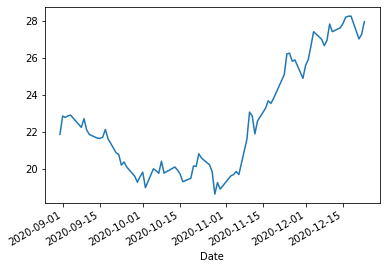

In [4]:
# Let´s see our time series with a basic plot
(df.AdjClose).plot();

## Important Clues:
As we see above the Time Series clearly does not show any stationarity, as the mean and variation aren´t constant during time interval. To greater time periods analysis, as we have a cyclical stock (oil & gas sector) in this case, we should be aware about seasonality, because oil price fluctuations may vary during specific dates and thus can impact stock prices of Petrobras

A simple way to get a stationary Time Series is to take the difference between Yt and Yt-p, regargind p as the number of difference intervals we´re considering. $ Delta(Y) = Y(t) - Y(t-p) $. Let´s plot below the stock prices difference with p = 1

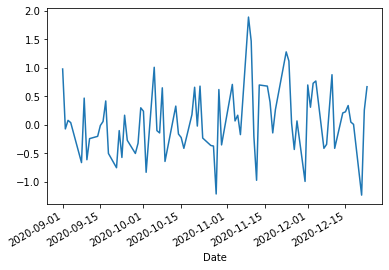

In [5]:
(df.AdjClose.diff(1)).plot();

Now we have a better candidate for Time Series Analysis with ARIMA, but one cannot guarantee statinarity by just looking at a graph. The final proof of deciding if this is a stationary serie or not is performing stationarity tests, like Augmented Dickey-Fuller Test (ADF test).

It´s also crucial to check if there are any correlation between $ Y(t+1) - Y(t) $. We can easily get a lag plot of prices with 1 lag.

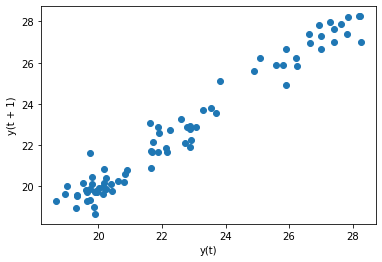

In [6]:
lag_plot(df.AdjClose, lag=1);

## Hypothesis
Now we know two things:  
1 - that we probably can get a stationary series using the differences  
2 - we certainly have some auto correlation in prices, which allow us to perform Auto Regression  

The next step is to check if hypothesis 1 is True. For this purpose, I chose the ADF test done below with both series: AdjClose and AdjClose differenced

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.AdjClose)
print ('-'*50)
print ('Non Stationary Time Series:')
print ('-'*50)
print ('ADF Test {}'.format(result[0]))
print ('p valor {}'.format(result[1]))
print ('Valores Críticos: ') 
for key, value in result[4].items():
      print ('\t{}:{}'.format(key, value))
        
print ('-'*50)

result_diff = adfuller(df.AdjClose.diff(1).dropna())
print ('Stationary Time Series:')
print ('-'*50)
print ('ADF Test {}'.format(result_diff[0]))
print ('p valor {}'.format(result_diff[1]))
print ('Valores Críticos: ') 
for key, value in result_diff[4].items():
      print ('\t{}:{}'.format(key, value))

--------------------------------------------------
Non Stationary Time Series:
--------------------------------------------------
ADF Test -0.001948875424229455
p valor 0.9583706183698666
Valores Críticos: 
	1%:-3.517113604831504
	5%:-2.8993754262546574
	10%:-2.5869547797501644
--------------------------------------------------
Stationary Time Series:
--------------------------------------------------
ADF Test -8.411536049107053
p valor 2.0973898845458657e-13
Valores Críticos: 
	1%:-3.518281134660583
	5%:-2.899878185191432
	10%:-2.5872229937594873


## ADF Results:
The Stock Prices without differencing isn´t stationary, as supposed by looking at the graph before. It´s clearly seen that the p-value is not significant for this ADF test (p=0.95)  
  
  But for the second ADF test using 1 period differencing, the series is proved stationary as the p value were significant and considerably low

## Getting ARIMA parameters  
  
  Now we need to get ARIMA $(p,1,q)$ paremeters. The d parameter equals 1, as we saw above that the ADF test for 1 difference is pretty good. You can try another d values by yourself. But as d rise, the time series shows more trend component. Try it!  

## Autocorrelation Plot
  
  The autocorrelation plot represents the Pearson´s correlations of the variables with themselves. As we´re dealing with stock prices, the autocorrelation tells us what´s the correlation between time t price and time t-p price, given p as the number os lags used. You can see on the Autocorrelation graph below that, as we increase the number of lags visualized, the correlation gradually drops. This can be interpreted in this way: more distant the time periods separating two prices, the less correlation there´re with them.

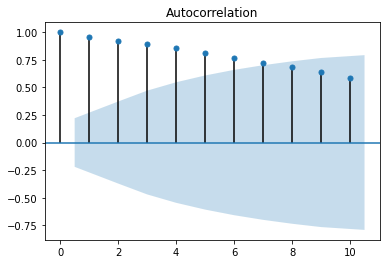

In [8]:
# From time series analysis plots importing ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.AdjClose, lags=10);

Note that for zero lags, the correlation can only be one, as the correlation of the stock price with itself can only be perfect.   But how do we choose the ideal value for Moving Average parameter $(q)$?    
  
  In this time I decided to pick up the number of lags that puts correlation into the blue cloud. That number is 7. So, <b>q = 7</b>

## Partial Autocorrelation Plot  
The partial autocorrelation plot (PACF) gives us the parameter $p$, as it reflects only the <b>direct</b> effect of past prices on the current price. We´re only interested in Autoregressive lags that gives us information gain. So, it doesn´t make sense to exploit lags that does not correlate with actual prices. It´s clear that as the graph tells us, the $p$ parameter that captures the most useful information to create our Time Series is $p = 1$. 
  
By now, we´ve already determined all the parameters to apply on ARIMA model: <b>$(p,d,q) = (1,1,7)$</b>

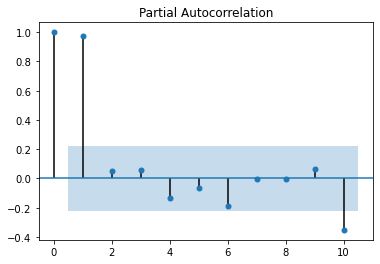

In [9]:
plot_pacf(df.AdjClose, lags=10);

## Building baseline predictions with Machine Learning Algorithms
  
  Let´s see if Linear Regression and Support Vector Regressor gives a good prediction. After importing Linear Regression, I´d set some values to p. We´ve already covered the p parameter above. You can also have some fun trying different values for p parameter below, but as stressed earlier, the ideal value in this case is 1.

In [10]:
from sklearn.linear_model import LinearRegression

p = 1

df1 = df[['AdjClose']].copy()
for i in range(p):
    df1[f'x_{i+1}'] = df1['AdjClose'].shift(i+1)
df1.dropna(axis=0, inplace=True)

X = df1.drop('AdjClose', axis=1)
y = df1['AdjClose']
train_size = int(len(X) * 2/3)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

lreg = LinearRegression()
lreg.fit(X_train, y_train)
print ('-'*50)
print ('Linear Regression RMSE: ', np.sqrt(((y_test - lreg.predict(X_test))**2).mean()))
print ('-'*50)

--------------------------------------------------
Linear Regression RMSE:  0.8112088090593764
--------------------------------------------------


## Evaluating results of LR: 
  
  As we´re treating a regression problem, with target variable being of numerical-continuous type, one way to evaluate the regression results is by looking at Root Mean Squared Error (RMSE). The reason why we should take a root of Mean Squared Error is to put results on an interpretable unit. In this case of stock prices prediction, the RMSE above tells that you can have a + or - 0.81 BRL error predicting a daily stock price. It seems pretty good but it´s actually not at all.
  
  If one intends to trade high amounts, this apparent low RMSE can cause a painfull damage to one´s trading account. Despite, if one trades a short amount of money, the benefits of profiting 0.81 BRL per stock doesn´t even pay transaction costs. So, I consider this result pretty bad btw!

## Plotting the predictions of LR... 

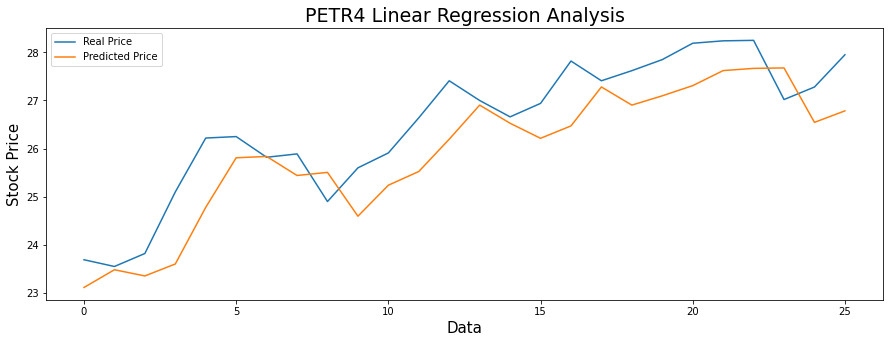

In [11]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(lreg.predict(X_test))
plt.title('PETR4 Linear Regression Analysis', fontsize=19)
plt.xlabel("Data", fontsize=15)
plt.ylabel("Stock Price", fontsize=15)
plt.legend(['Real Price', 'Predicted Price']);

Let´s do the same thing but now with a different regression model: SVR. The idea is absolutely the same of RFR model, the only difference is that rather than using RFR model, I use SVR.

In [12]:
from sklearn.svm import SVR
p = 1

df1 = df[['AdjClose']].copy()
for i in range(p):
    df1[f'x_{i+1}'] = df1['AdjClose'].shift(i+1)
df1.dropna(axis=0, inplace=True)

X = df1.drop('AdjClose', axis=1)
y = df1['AdjClose']
train_size = int(len(X) * 2/3)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

reg = SVR(kernel='linear')
reg.fit(X_train, y_train)
print ('-'*50)
print ('Support Vector Regressor RMSE: ', np.sqrt(((y_test - reg.predict(X_test))**2).mean()))
print ('-'*50)

--------------------------------------------------
Support Vector Regressor RMSE:  0.85164947479154
--------------------------------------------------


## Evaluating results of SVR:
  
  Very similar to Linear Regression, but also high if we consider the reality involved in trading. Let´s see a plot below

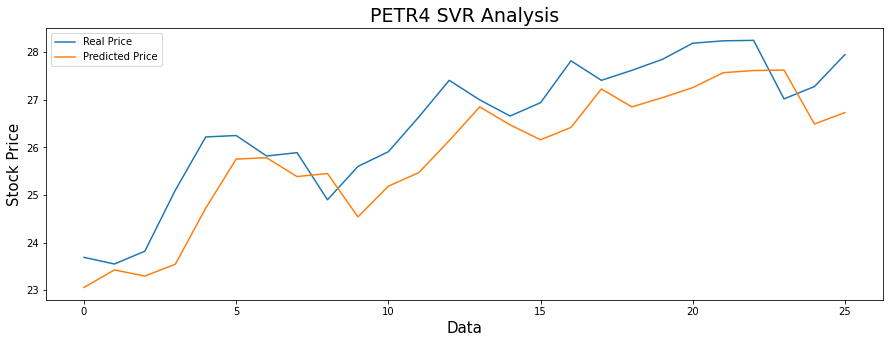

In [13]:
plt.figure(figsize=(15,5))
plt.plot(y_test.values)
plt.plot(reg.predict(X_test))
plt.title('PETR4 SVR Analysis', fontsize=19)
plt.xlabel("Data", fontsize=15)
plt.ylabel("Stock Price", fontsize=15)
plt.legend(['Real Price', 'Predicted Price']);

# ARIMA model
  
  If you remember, I´ve already defined the ARIMA parameters before. They´re $(p,d,q) = (1,1,7)$. Next, we must import the ARIMA method from statsmodels below and segregate our dataset into training set and testing set.
  
  <b>Important</b>: One must never randomize train and test set when working with time series! By doing this, the randomization proccess brokes up all the logic behind the variable during the time of analysis. Never forget it!

In [14]:
from statsmodels.tsa.arima_model import ARIMA

<b>Slicing dataset into train and test WITHOUT randomization</b>

In [15]:
train_set = df.AdjClose[:int(len(df)*0.7)]
test_set = df.AdjClose[int(len(df)*0.7):]

## Fitting ARIMA model
  
  Now it´s time to fit our train_set in ARIMA model, giving p, d and q parameters as order tuple.

In [16]:
arima1_train = ARIMA(train_set, order=(1,1,7)).fit()

C:\Users\jrapo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jrapo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


After fitting the ARIMA model, we´ll see how it perform on test set. I ensure to use train set fitted ARIMA parameters to fit the test set, because we´re interested to see how ARIMA predictions perform on new prices.

In [17]:
arima1_test = ARIMA(test_set, order=(1,1,7)).fit(arima1_train.params)

C:\Users\jrapo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jrapo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\jrapo\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


## Results of ARIMA
  
You can check below that ARIMA RMSE is considerably lower than Linear Regression and SVR RMSE´s. This result comes to show us that in some situations it´s worth using a simple model than a more complex one, like SVR. Despite the complexity profiles, ARIMA performed better than the last two regression models.

In [18]:
print ('-'*50)
print ('ARIMA RMSE: ', np.sqrt((arima1_test.resid ** 2).mean()))
print ('-'*50)

--------------------------------------------------
ARIMA RMSE:  0.5127034562810066
--------------------------------------------------


## Plotting the Graph...

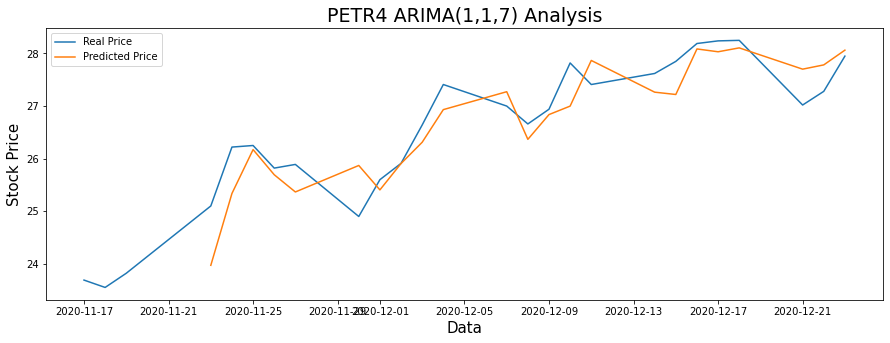

In [19]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(arima1_test.predict(typ='levels'))
plt.title('PETR4 ARIMA(1,1,7) Analysis', fontsize=19)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.legend(['Real Price', 'Predicted Price']);

## Predicting next day close
  
  Finally, we can use our ARIMA model fitted on test set to predict the next day adjusted close price from PETR4 stock. Let´s see what happens!
  
  <b>NOTE:</b> This study <b>IS NOT</b> a buy/sell recommendation! The study had only educational purpose and dealing with stock prices there are not <b>any</b> guarantee of future prices or future returns.

In [20]:
future_day_price = arima1_test.forecast()[0]
print ('2020 Dec 23 Close Price: ' + str(27.95)+' BRL')
print ('-'*50)
print ('2020 Dec 28 PETR4 Close Price Prediction :', future_day_price,'BRL')

2020 Dec 23 Close Price: 27.95 BRL
--------------------------------------------------
2020 Dec 28 PETR4 Close Price Prediction : [28.8538667] BRL
